In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time#, calendar
import requests, re
from bs4 import BeautifulSoup
#import graphlab as gl
%matplotlib inline

# Reading from json file for testing

In [2]:
with open("/Users/johnnysand/GalvanizeDS/final_project/test_set.json", "rb") as f:
    test_file = f.readlines()

```python
import pandas as pd

# read the entire file into a python array
with open('your.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)
```

In [3]:
test_file = map(lambda x: x.strip(), test_file)
test_json = "[" + ','.join(test_file) + "]"

In [4]:
df = pd.read_json(test_json)

Remove private users (no friend, game, profile, or location info  
Remove users who have "empty" game_info 
Remove users with null values  
Remove users with "empty" profile_summary

In [8]:
public_df = df[df["friends"] != "private"]
public_df = public_df[public_df["game_info"]!="empty"]
public_df = public_df[~public_df["game_info"].isnull()]["game_info"]

In [66]:
public_df = unpack(public_df, "ban_status", fillna=None)

In [71]:
public_df = public_df[~public_df["profile_summary"].isnull()]

In [76]:
public_df = public_df[public_df["profile_summary"]!="empty"]

In [77]:
public_df = unpack(public_df, "profile_summary", fillna=None)

In [17]:
public_df = unpack(public_df, "user_info", fillna=None)

In [106]:
public_df[public_df["loccountrycode"]=="US"]["locstatecode"].unique()

array([u'LA', u'IN', u'AK', u'CO', u'IL', u'NE', nan, u'AZ', u'OK', u'TX',
       u'OR', u'CA', u'WA', u'NV', u'NY', u'FM', u'VA', u'GA', u'UT',
       u'MN', u'FL', u'NJ', u'MO', u'MT', u'PA', u'NC', u'MI', u'KY',
       u'OH', u'WI', u'MA', u'AR', u'ID', u'KS', u'SC', u'AL', u'TN',
       u'DE', u'VT', u'CT', u'HI', u'ME', u'IA', u'ND', u'NM', u'WV',
       u'RI', u'MD', u'DC', u'WY', u'NH', u'AS', u'MS', u'SD', u'GU',
       u'PW', u'MP', u'VI', u'PR'], dtype=object)

In [100]:
public_df = public_df[~public_df["game_info"].isnull()]

In [101]:
popular_games = popular_game_set(public_df)

KeyboardInterrupt: 

# Connect to MongoDB

In [2]:
conn = pymongo.MongoClient()['steam']
cursor = conn['test'].find({})

In [3]:
df = pd.DataFrame(list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 7 columns):
_id                656 non-null object
ban_status         656 non-null object
friends            656 non-null object
game_info          656 non-null object
profile_summary    656 non-null object
steamid            656 non-null object
user_info          656 non-null object
dtypes: object(7)
memory usage: 35.9+ KB


In [4]:
df.head(1)

,_id,ban_status,friends,game_info,profile_summary,steamid,user_info
0,570fc54763210f0e63d825fc,"{u'NumberOfGameBans': 0, u'NumberOfVACBans': 0...","[{u'steamid': u'76561197962935145', u'friend_s...","[{u'playtime_forever': 63, u'playtime_2weeks':...",No information given.,76561197981918203,"{u'timecreated': 1144367341, u'personaname': u..."


In [5]:
class CleanData(object):
    """
    Class to clean up a data frame directly
    from json or MongoDB
    """
    
    def __init__(self, df):
        self.df = df[df["game_info"] != "empty"]
        del self.df["_id"]
        self.private = self.df[self.df["friends"] == "private"]
        self.public = self.df[self.df["friends"] != "private"]
        self.cols = set(["profile_summary", "ban_status", "user_info"])
        
        self.profile_summary = None
        self.public_bans = None
        self.public_users = None
        
        self.private_bans = None
        self.private_users = None
        
        
    def __remove_columns(self, private=True):
        """
        Remove unused columns
        """
        
        if private:
            del_columns = set(["friends","game_info","profile_summary","loccityid","loccountrycode",\
                         "locstatecode","ban_status","user_info","realname","timecreated",\
                         "primaryclanid","communityvisibilitystate","commentpermission"])
            for col in del_columns:
                try:
                    del self.private[col]
                except KeyError:
                    continue
                
        else:
            del_columns = set(["gameextrainfo", "gameid", "gameserverip", "gameserversteamid",\
                               "lobbysteamid", "loccityid"])
            for col in del_columns:
                try:
                    del self.public[col]
                except KeyError:
                    continue
                               
            
        
        
    def ban_status_df(self, private=True):
        """
        Convert a df with a column of single dictionaries and 
        a steamid
        Returns a df with the unpacked dictionaries
        """
        if private:
            new_df = pd.DataFrame()
            for i in xrange(self.private.steamid.count()):
                self.private.iloc[i]["ban_status"]["steamid"] = self.private.iloc[i]["steamid"]
                user_df = pd.DataFrame(self.private.iloc[i]["ban_status"], index=[0])
                new_df = new_df.append(user_df)
            self.private_bans = new_df
        
        else:   
            new_df = pd.DataFrame()
            for i in xrange(self.public.steamid.count()):
                self.public.iloc[i]["ban_status"]["steamid"] = self.public.iloc[i]["steamid"]
                user_df = pd.DataFrame(self.public.iloc[i]["ban_status"], index=[0])
                new_df = new_df.append(user_df)
            self.public_bans = new_df
    
    
    def user_info_df(self, private=True):
        """
        Convert a df with a column of single dictionaries and 
        a steamid
        Returns a df with the unpacked dictionaries
        """
        if private:
            new_df = pd.DataFrame()
            for i in xrange(self.private.steamid.count()):
                self.private.iloc[i]["user_info"]["steamid"] = self.private.iloc[i]["steamid"]
                user_df = pd.DataFrame(self.private.iloc[i]["user_info"], index=[0])
                new_df = new_df.append(user_df)
            self.private_users = new_df
        
        else:   
            new_df = pd.DataFrame()
            for i in xrange(self.public.steamid.count()):
                self.public.iloc[i]["user_info"]["steamid"] = self.public.iloc[i]["steamid"]
                user_df = pd.DataFrame(self.public.iloc[i]["user_info"], index=[0])
                new_df = new_df.append(user_df)
            self.public_users = new_df
     
    
    def profile_summary_df(self):
        """
        Convert a df with a column of single dictionaries and 
        a steamid
        Returns a df with the unpacked dictionaries
        """  
        new_df = pd.DataFrame()
        for i in xrange(self.public.steamid.count()):
            self.public.iloc[i]["profile_summary"]["steamid"] = self.public.iloc[i]["steamid"]
            user_df = pd.DataFrame(self.public.iloc[i]["profile_summary"], index=[0])
            new_df = new_df.append(user_df)
        self.profile_summary = new_df
        
    
    def merge_dfs(self, private=True):
        """
        Merge dataframes on the "steamid" column
        """
        if private:
            self.private = pd.merge(pd.merge(self.private, self.private_bans,\
                           on='steamid'), self.private_users, on='steamid')
            
        else:
            self.public = pd.merge(pd.merge(self.public, self.public_bans,\
                           on='steamid'), self.public_users, on='steamid')
            del self.public["ban_status"]
            del self.public["user_info"]
            
    
    def do_many_things(self, private=True):
        """
        Call the above functions to build the 
        world's most average dataframe
        """
        
        self.ban_status_df(private)
        self.user_info_df(private)
        self.merge_dfs(private)
        self.__remove_columns(private)

In [6]:
test = CleanData(df)

In [8]:
t0 = time.time()
#test.do_many_things(private=False)
test.do_many_things(private=True)
print time.time() - t0

2.06585597992


In [16]:
class CleanDictList(object):
    
    def __init__(self, df):
        self.games = df[["game_info", "steamid"]]
        self.friends = df[["friends", "steamid"]]
        self.popular_games = None
        
    def games_df(self):
        games_count = Counter()
        user_playtime = []
        num_games = []
        num_played_total = []
        for user in self.games["game_info"]:
            game_dict = dict()
            num_played = 0
            for game in user:
                appid = game["appid"]
                game_dict[appid] = game["playtime_forever"]
                if game["playtime_forever"]:
                    num_played += 1
            num_played_total.append(num_played)   
            num_games.append(len(user))
            user_playtime.append((sum(game_dict.values())))
            games_count.update(game_dict)
            
        
        average_playtime = int(sum(games_count.values()) / float(len(games_count)))
        popular = dict()
        for game, time in games_count.iteritems():
            if time >= average_playtime:
                popular[game] = time
        self.popular_games = popular
        self.games["total_playtime"] = user_playtime
        self.games["games_owned"] = num_games
        self.games["games_played"] = num_played_total
    
    def friends_df(self):
        
        for user in self.friends["game_info"]:
            game_dict = dict()
            num_played = 0
            for game in user:
                appid = game["name"]
                game_dict[appid] = game["playtime_forever"]
                if game["playtime_forever"]:
                    num_played += 1
            num_played_total.append(num_played)   
            num_games.append(len(user))
            user_playtime.append((sum(game_dict.values())))
            games_count.update(game_dict)

In [17]:
Games = CleanDictList(test.public)

In [18]:
Games.games_df()

/Users/johnnysand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/johnnysand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/johnnysand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

# Scrape Genres From Store Page For Most Popular Games

In [323]:
568022401 / (3600. * 24 * 365)

18.011872177828515

In [13]:
game_traits = []
for appid in popular_games.keys():

    url = "https://store.steampowered.com/app/"+str(appid)
    cookies = {'birthtime': '568022401'}
    try:
        response = requests.get(url, cookies=cookies)
        rm_delims = re.sub(r"[\t\r\n]+", r"", response.text)
        rm_breaks = re.sub(r"\<br\>+", r"", rm_delims).strip()
        soup = BeautifulSoup(rm_breaks, "html.parser")
        top_genres = [tag.text for tag in soup.find_all("a", "app_tag")[:5]]
        try:
            release_date = soup.select_one("span.date").text
        except AttributeError:
            release_date = None
        game_traits.append({"date": release_date, "genres": top_genres, "appid":appid})
        popular_games[appid] = top_genres
    except requests.ConnectionError:
        time.sleep(10)
        response = requests.get(url, cookies=cookies)
        rm_delims = re.sub(r"[\t\r\n]+", r"", response.text)
        rm_breaks = re.sub(r"\<br\>+", r"", rm_delims).strip()
        soup = BeautifulSoup(rm_breaks, "html.parser")
        top_genres = [tag.text for tag in soup.find_all("a", "app_tag")[:5]]
        try:
            release_date = soup.select_one("span.date").text
        except AttributeError:
            release_date = None
        game_traits.append({"date": release_date, "genres": top_genres, "appid":appid})
        popular_games[appid] = top_genres
        

In [7]:
url = "https://store.steampowered.com/app/730"
cookies = {'birthtime': '568022401'}

In [8]:
response = requests.get(url, cookies=cookies)
rm_delims = re.sub(r"[\t\r\n]+", r"", response.text)
rm_breaks = re.sub(r"\<br\>+", r"", rm_delims).strip()
soup = BeautifulSoup(rm_breaks, "html.parser")

In [11]:
soup.select_one("span.date").text

u'Aug 21, 2012'

In [15]:
game_df = pd.DataFrame(game_traits)

In [22]:
game_df = game_df.dropna()

In [23]:
game_df.head()

,appid,date,genres
0,220160,"Mar 21, 2013","[Racing, Action, Level Editor, Multiplayer, Pl..."
1,212480,"Jan 31, 2013","[Racing, Local Multiplayer, Multiplayer, Great..."
2,17410,"Jan 13, 2009","[Parkour, First-Person, Action, Female Protago..."
3,224260,"Oct 31, 2011","[Free to Play, Zombies, Multiplayer, Survival,..."
4,230230,"Jun 30, 2014","[RPG, Turn-Based, Co-op, Fantasy, Adventure]"


In [45]:
genre_df = pd.DataFrame()
for genre in game_df.genres:
    genre_tracker = Counter()
    genre_tracker.update(genre)
    genre_df = genre_df.append(genre_tracker, ignore_index=True)

In [47]:
genre_df = genre_df.fillna(0)

In [157]:
combo_df.date = combo_df.date.dt.year

In [56]:
game_df.date = pd.to_datetime(game_df.date, dayfirst=True)

In [273]:
combo_df = pd.concat([game_df, genre_df], axis=1)

In [274]:
combo_df = combo_df.dropna()

In [169]:
combo_df.date = combo_df.date.astype(int)

In [1]:
150000*2000

300000000

In [305]:
sum_action = np.array([])
sum = 0
for game in combo_df.Indie:
    sum += game
    sum_action = np.append(sum_action, sum)

In [286]:
sum_open_world = np.array([])
sum = 0
for game in combo_df["Open World"]:
    sum += game
    sum_open_world = np.append(sum_open_world, sum)

In [288]:
sum_multi = np.array([])
sum = 0
for game in combo_df.Multiplayer:
    sum += game
    sum_multi = np.append(sum_multi, sum)

In [300]:
sum_fps = np.array([])
sum = 0
for game in combo_df.FPS:
    sum += game
    sum_fps = np.append(sum_fps, sum)

In [282]:
combo_df = combo_df.sort_values(by="date")

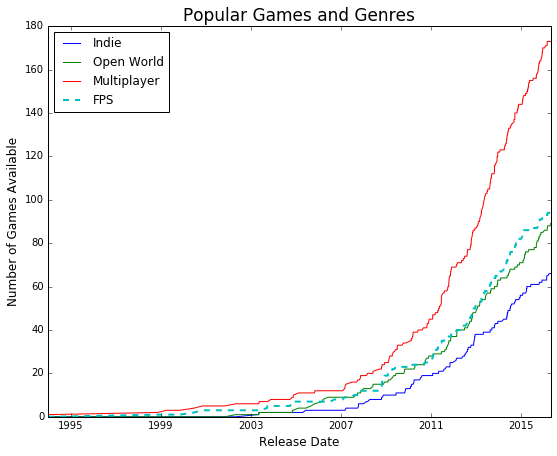

In [313]:
plt.figure(figsize=(9,7))
plt.plot(combo_df.date, sum_action, label="Indie")
plt.plot(combo_df.date, sum_open_world, label="Open World")
plt.plot(combo_df.date, sum_multi, label="Multiplayer")
plt.plot(combo_df.date, sum_fps, ls="--", lw=2, label="FPS")
plt.legend(loc="upper left")
plt.xlabel("Release Date", fontsize=12)
plt.ylabel("Number of Games Available", fontsize=12)
plt.title("Popular Games Available", fontsize=17)
plt.show()

In [178]:
combo_df[combo_df.date == 1993].sum().sum()-1993

5.0

In [229]:
len(rm_date[combo_df.date == 2003].sum())

207

In [198]:
rm_date = combo_df.copy()
del rm_date["date"]

In [304]:
rm_date[combo_df.date.dt.year == 2012].sum().sort_values(ascending=False) / len(rm_date[combo_df.date.dt.year == 2012])

/Users/johnnysand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Action                      0.525424
Multiplayer                 0.305085
Indie                       0.220339
FPS                         0.220339
RPG                         0.220339
Open World                  0.203390
Free to Play                0.169492
Strategy                    0.169492
Singleplayer                0.152542
Sci-fi                      0.118644
Shooter                     0.118644
Rogue-like                  0.101695
Co-op                       0.101695
Massively Multiplayer       0.084746
Zombies                     0.084746
Simulation                  0.084746
Survival                    0.067797
First-Person                0.067797
Space                       0.067797
Post-apocalyptic            0.050847
Pixel Graphics              0.050847
Third-Person Shooter        0.050847
Anime                       0.050847
Turn-Based Strategy         0.050847
Platformer                  0.050847
Turn-Based                  0.050847
Fantasy                     0.050847
G

In [272]:
game_df.head()

,appid,date,genres
0,220160,2013-03-21,"[Racing, Action, Level Editor, Multiplayer, Pl..."
1,212480,2013-01-31,"[Racing, Local Multiplayer, Multiplayer, Great..."
2,17410,2009-01-13,"[Parkour, First-Person, Action, Female Protago..."
3,224260,2011-10-31,"[Free to Play, Zombies, Multiplayer, Survival,..."
4,230230,2014-06-30,"[RPG, Turn-Based, Co-op, Fantasy, Adventure]"


In [254]:
genre_time = pd.groupby(combo_df, by=combo_df.date)[["Action", "Multiplayer", "Indie", "Open World", "Zombies"]].sum()

In [267]:
combo_df.groupby("date").sum()

,Action,Level Editor,Multiplayer,Platformer,Racing,Great Soundtrack,Local Co-Op,Local Multiplayer,Female Protagonist,First-Person,...,Robots,1980s,Education,Arena Shooter,Time Travel,Lore-Rich,Flight,Bowling,Politics,Turn-Based Combat
date,,,,,,,,,,,,,,,,,,,,,
1993,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,4.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
for i, date in enumerate(genre_time.index):
    genre_time.iloc[i] = genre_time.iloc[i] / (207 * len(rm_date[combo_df.date == date]))
    

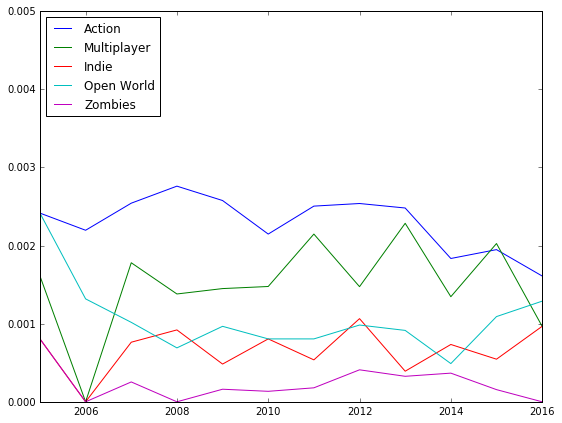

In [268]:
plt.figure(figsize=(9,7))
plt.plot(genre_time.index, genre_time.Action, label="Action")
plt.plot(genre_time.index, genre_time.Multiplayer, label="Multiplayer")
plt.plot(genre_time.index, genre_time.Indie, label="Indie")
plt.plot(genre_time.index, genre_time["Open World"], label="Open World")
plt.plot(genre_time.index, genre_time.Zombies, label="Zombies")
plt.legend(loc="upper left")
plt.xlim(2005, 2016)
plt.show()


In [96]:
playtimes = Games.games

In [126]:
np.array(test.public.head())[:,3]

array([u'76561197981918203', u'76561197993408842', u'76561198042305043',
       u'76561197980092471', u'76561198202663196'], dtype=object)

In [107]:
playtimes.games_owned.mean()

132.24175824175825

In [108]:
playtimes.games_played.mean()

71.8956043956044

In [322]:
abc = [1, 2, 3, 4, 5, 6, 7, 7, 8]
x[num for num in abc if num != 7]


[1, 2, 3, 4, 5, 6, 8]

In [321]:
abc

[1, 2, 3, 4, 5, 6, 7, 8]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 0 to 545
Data columns (total 22 columns):
friends                     546 non-null object
game_info                   546 non-null object
profile_summary             546 non-null object
steamid                     546 non-null object
CommunityBanned             546 non-null bool
DaysSinceLastBan            546 non-null int64
EconomyBan                  546 non-null object
NumberOfGameBans            546 non-null int64
NumberOfVACBans             546 non-null int64
VACBanned                   546 non-null bool
avatarfull                  546 non-null object
commentpermission           90 non-null float64
communityvisibilitystate    546 non-null int64
lastlogoff                  546 non-null int64
loccountrycode              359 non-null object
locstatecode                269 non-null object
personaname                 546 non-null object
personastate                546 non-null int64
primaryclanid               546 non-null 

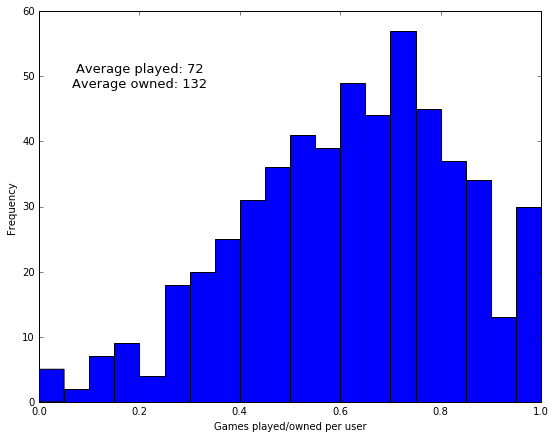

In [114]:
plt.figure(figsize=(9,7))
plt.hist(playtimes.games_played / playtimes.games_owned, bins=20)
#plt.hist(playtimes.games_played, bins=15, alpha=0.5, label="Played")
#plt.hist(playtimes.games_owned, bins=15, alpha=0.5, label="Owned")
plt.xlabel("Games played/owned per user")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
plt.text(0.2, 50,'Average played: 72\nAverage owned: 132', ha='center', va='center', fontsize=13)
plt.show()

# Split up users based on public or private profiles

In [ ]:
df2 = df.copy()
private_df = df2[df2["profile_summary"] == "private"]
public_df = df2[df2["profile_summary"] != "private"]

In [ ]:
private_df.info()

In [ ]:
private_df["VACBanned"].value_counts()#`.replace(["none"], 0).value_counts()

# Who needs these columns?

In [ ]:
del public_df["_id"]
del public_df["gameid"]
del public_df["commentpermission"]
del public_df["gameserverip"]
del public_df["gameserversteamid"]
del public_df["gameextrainfo"]

In [ ]:
public_df.head()

# Some Friend Exploration

In [ ]:
friends = public_df.copy()
friends = friends[["steamid", "friends"]]

In [ ]:
friends.head()

In [ ]:
for friend in friends["friends"][0]:
    print friend

In [ ]:
def friends_users_list(df, pivot=False):
    """
    Assumes a df with public non-null values in the form:
    |   |steamid          |friends          |
    +---+-----------------+-----------------+
    |0  |76561197967398882|[{u'frien...},{}]|
    
    Returns a pivoted data fram where each row is
    'steamid', the columns are game names, and the 
    values are 'playtime_forever' (default) or 
    'playtime_2weeks'
    """
    df = df.set_index("steamid")
    for i in xrange(len(df)):
        
        #[game.update({"steamid":df.iloc[i].name})\
        #           for game in df.iloc[i]["game_info"]\
        #           if str(game["appid"]) in game_id_set]
        
        for friend in df.iloc[i]["friends"]:
            #if str(friend["appid"]) in game_id_set:
            #    game.update({"steamid":df.iloc[i].name})
            #else:
                #df.iloc[i]["game_info"].remove(game)
            friend.update({"uid":df.iloc[i].name})
    
    full_friend_df = pd.DataFrame()
    for user in df["friends"]:
        frienddf = pd.DataFrame(user)
        full_friend_df = full_friend_df.append(frienddf)
    
    #if pivot:
    #    full_gamedf = pd.pivot_table(full_gamedf, index="steamid", columns=["appid"], values="playtime_forever", fill_value=0)
    return full_friend_df

In [ ]:
large_friends = friends_users_list(friends)

In [ ]:
len(large_friends[large_friends["friend_since"] == 0]["steamid"].unique())

In [ ]:
friendship_length = (calendar.timegm(time.gmtime()) - longest_frienship)/(3600*24*360.)

In [ ]:
friendship_length

In [ ]:
[friend for friend in friends.iloc[0]["friends"]]

In [95]:
def popular_game_set(df):
    """
    Pull out only game appids from 'game_info' whose global 
    forever_playtime is above the average glabal playtime, 
    reducing the number of apps about 90%
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame with column 'game_info', containing
        a list of dictionaries
         
    Returns
    -------
    popular_games : set
        Set of game appids whose global playtime is 
        above the average global playtime
    """
    # Collect the appid and global playtime for each game
    # That all users have played
    
    summed = Counter({})
    for user in df["game_info"]:
        gametime = Counter({})
        for game in user:
            gametime[str(game["appid"])] = game["playtime_forever"]
            if game["appid"] not in summed.keys():
                summed.update(gametime)
        summed += gametime
        
    global_averages = int(np.mean(summed.values()))
    
    # Condense into a set of popular appids
    
    popular_games = set()
    for k, v in summed.iteritems():
        if v >= global_averages:
            popular_games.add(k)
    
    return popular_games

In [ ]:
popular_games = popular_game_set(public_df)

In [ ]:
games = public_df.copy()
games = games[["steamid", "game_info"]]
#games = games.set_index("steamid")
games.head()

# Pivot Table

In [ ]:
def games_users_list(df, game_id_set, pivot=False):
    """
    Assumes a df with public non-null values in the form:
    |   |steamid          |game_info        |
    +---+-----------------+-----------------+
    |0  |76561197967398882|[{u'playt...},{}]|
    
    Returns a pivoted data fram where each row is
    'steamid', the columns are game names, and the 
    values are 'playtime_forever' (default) or 
    'playtime_2weeks'
    """
    df = df.set_index("steamid")
    for i in xrange(len(df)):
        
        #[game.update({"steamid":df.iloc[i].name})\
        #           for game in df.iloc[i]["game_info"]\
        #           if str(game["appid"]) in game_id_set]
        
        for game in df.iloc[i]["game_info"]:
            if str(game["appid"]) in game_id_set:
                game.update({"steamid":df.iloc[i].name})
            else:
                df.iloc[i]["game_info"].remove(game)
    
    full_gamedf = pd.DataFrame()
    for user in df["game_info"]:
        gamedf = pd.DataFrame(user)
        full_gamedf = full_gamedf.append(gamedf)
    
    if pivot:
        full_gamedf = pd.pivot_table(full_gamedf, index="steamid", columns=["appid"], values="playtime_forever", fill_value=0)
    return full_gamedf

In [ ]:
games_matrix = sparse_games(games, popular_games)
games_matrix.head()

# Bin columns based on playtime
* ### Add a weight for profile age?


|playtime [min]|     rating     |
|--------------|----------------|
|    0         |      0         |
|    1-60      |      1         |
|    61-120    |      2         |
|    121-600   |      3         |
|    601-1200  |      4         |
|    1201 +    |      5         |
`pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)`

In [ ]:
profile_length = (calendar.timegm(time.gmtime()) - public_df["timecreated"])/(3600*24*365) # In years

In [ ]:
plt.figure(figsize=(9,7))
plt.hist(profile_length, bins=15, color='c')
plt.ylabel("Frequency", fontsize=15)
plt.vlines(profile_length.mean(), 0, 70, lw=2, alpha=0.5,\
           label="Average: {} years".format(round(profile_length.mean(),1)))
plt.xlabel("Time [years]", fontsize=15)
plt.title("Profile Length of 550 Users", fontsize=20)
plt.legend(loc="upper left", prop={"size":12})
plt.show()

In [ ]:
dota2 = games_matrix.playtime_forever[570]
csgo = games_matrix.playtime_forever[730]
skyrim = games_matrix.playtime_forever[72850]
tf2 = games_matrix.playtime_forever[440]

In [ ]:
dota2_vals = pd.cut(dota2, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
csgo_vals = pd.cut(csgo, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
skyrim_vals = pd.cut(skyrim, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
tf2_vals = pd.cut(tf2, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()#, labels=[0,1,2,3,4,5]

In [ ]:
plt.figure(figsize=(9,7))
ax = plt.subplot(111)
ax.bar(np.array(dota2_vals.index)-0.3, dota2_vals.values, width=0.2, align="center", alpha=0.7, color='b', label="Dota 2")
ax.bar(np.array(skyrim_vals.index)+0.3, skyrim_vals.values, width=0.2, align="center", alpha=0.7, color='g', label="Skyrim")
ax.bar(np.array(csgo_vals.index)-0.1, csgo_vals.values, width=0.2, align="center", alpha=0.7, color='r', label="CS:GO")
ax.bar(np.array(tf2_vals.index)+0.1, tf2_vals.values, width=0.2, align="center", alpha=0.7, color='c', label="TF2 (free)")
ax.legend(loc="upper right", prop={'size':20})
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Rating", fontsize=15)
plt.title("Playtime to Rating Conversion", fontsize=20)
plt.show()

In [ ]:
adjusted_games = games_matrix.copy()

In [ ]:
game_ratings = pd.DataFrame()
for col in adjusted_games["playtime_forever"]:
    adjusted_column = pd.cut(adjusted_games["playtime_forever"][col],\
                                              bins=[-1, 0, 60, 120, 600, 1200, 10e10],\
                                              labels=[0,1,2,3,4,5])
    game_ratings[col] = adjusted_column

In [ ]:
game_ratings.head()

# Attempted Modeling?
```python
item_similarity_recommender
factorization_recommender
item_similarity_recommender
ranking_factorization_recommender

data = graphlab.SFrame({'user_id': ["Ann", "Ann", "Ann", "Brian", "Brian", "Brian"],
                          'item_id': ["Item1", "Item2", "Item4", "Item2", "Item3", "Item5"],
                          'rating': [1, 3, 2, 5, 4, 2]})
m = graphlab.factorization_recommender.create(data, target='rating')

recommendations = m.recommend()
```
### [GraphLab - Choosing a model](https://dato.com/learn/userguide/recommender/choosing-a-model.html)

In [ ]:
games_users_ratings.tail()

In [ ]:
gl_data = gl.SFrame({'user_id': games_users_ratings["steamid"],
                          'item_id': games_users_ratings["appid"],
                          'rating': games_users_ratings["ratings_forever"]})
model = gl.factorization_recommender.create(gl_data, target='rating')
similar_users = model.get_similar_users(["76561198046747311"], k=5)
similar_users

In [ ]:
model = gl.factorization_recommender.create(gl_data, target='rating')

In [ ]:
games_users_ratings[games_users_ratings["steamid"]=="76561198089389797"].sort_values(by="playtime_forever", ascending=False).head(10)

In [ ]:
games_users_ratings[games_users_ratings["steamid"]=="76561198046747311"].sort_values(by="playtime_forever", ascending=False).head(10)

In [ ]:
games_users_ratings = games_users_list(games, popular_games)

In [ ]:
games_users_ratings["ratings_forever"] = pd.cut(games_users_ratings["playtime_forever"],\
                                          bins=[-1, 0, 60, 120, 600, 1200, 10e10], \
                                          labels=[0,1,2,3,4,5])
games_users_ratings["ratings_2weeks"] = pd.cut(games_users_ratings["playtime_2weeks"],\
                                          bins=[-1, 0, 60, 120, 600, 1200, 10e10], \
                                          labels=[0,1,2,3,4,5])
games_users_ratings.tail()

In [ ]:
games_users_ratings[games_users_ratings["name"]=="Half-Life 2"].sort_values(by="playtime_forever")